### Examine the results of ANOVA with sliding window: 
- can ask, number of units encoding beliefs, confidence, preference across time, by regions
- fraction of variance explained by beliefs, confidence, preference across time, by regions

### Imports

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

### Helper functions

In [6]:
MODES = ["BeliefPartition", "BeliefPref", "BeliefConf"]

def num_units_by_time(args, percentile_str, modes=MODES, region_level="structure_level2", region=None):
    all_num_units = []
    for mode in modes: 
        res = io_utils.read_anova_good_units(args, percentile_str, mode)
        if region: 
            res = res[res[region_level] == region]
        num_units = res.groupby(["WindowEndMilli", "feat"]).PseudoUnitID.nunique().reset_index(name="num_units")
        num_units["mode"] = mode
        all_num_units.append(num_units)
    return pd.concat(all_num_units)

def compute_total_frac_vars(x, modes):
    # print(x.x_NextBeliefPref_comb_time_fracvar)
    total_pop_var = x.total_var.sum()

    return pd.Series({m: (x[f"x_{m}_comb_time_fracvar"] * x.total_var).sum() / total_pop_var for m in modes})

def frac_var_by_time(args, modes, use_base_partitition=False, region_level="structure_level2", regions=None):
    res = io_utils.read_anova_good_units(args, "all", "", return_pos=(regions is not None))
    if "NextBeliefConf" in modes:
        next_args = copy.deepcopy(args)
        next_args.conditions = ["NextBeliefConf", "NextBeliefPartition"]
        next_res = io_utils.read_anova_good_units(next_args, "all", "", return_pos=(regions is not None))
        res = pd.merge(res, next_res, on=["PseudoUnitID", "feat", "WindowEndMilli", "WindowStartMilli"], suffixes=(None, "_y"))
    if regions: 
        # res = res[res[f"{region_level}_x"] == region] 
        res = res[res[region_level].isin(regions)] 

    total_fracs = res.groupby(["feat", "WindowEndMilli"]).apply(lambda x: compute_total_frac_vars(x, modes)).reset_index()
    if use_base_partitition:
        partition_frac_vars = total_fracs["partition"].copy()
        for mode in ["partition", "conf", "pref"]:
            total_fracs[mode] = total_fracs[mode] / partition_frac_vars
    # value_vars = ["partition", "conf", "pref", "policy"]
    total_fracs = pd.melt(total_fracs, id_vars=["feat", "WindowEndMilli"], value_vars=modes, var_name="partition_type", value_name="frac_variance")
    total_fracs["trial_event"] = args.trial_event
    return total_fracs

def plot_conf_pref(args, percentile_str, region=None):
    args.trial_event = "StimOnset"
    # stim_num_units = num_units_by_time(args, "95th", modes=["BeliefPref"])
    stim_num_units = num_units_by_time(args, percentile_str, region=region)

    args.trial_event = "FeedbackOnsetLong"
    # fb_num_units = num_units_by_time(args, "95th", modes=["BeliefPref"])
    fb_num_units = num_units_by_time(args, percentile_str, region=region)    

    fig, axs = plt.subplots(
        2, 2, 
        figsize=(10, 6), 
        sharey='row', 
        width_ratios=[stim_num_units.WindowEndMilli.nunique(), fb_num_units.WindowEndMilli.nunique()]
    )
    sns.lineplot(stim_num_units[stim_num_units["mode"]=="BeliefConf"], x="WindowEndMilli", y="num_units", hue="mode", ax=axs[0, 0])
    sns.lineplot(fb_num_units[fb_num_units["mode"]=="BeliefConf"], x="WindowEndMilli", y="num_units", hue="mode", ax=axs[0, 1])

    sns.lineplot(stim_num_units[stim_num_units["mode"]=="BeliefPref"], x="WindowEndMilli", y="num_units", hue="mode", ax=axs[1, 0])
    sns.lineplot(fb_num_units[fb_num_units["mode"]=="BeliefPref"], x="WindowEndMilli", y="num_units", hue="mode", ax=axs[1, 1])

    if region is not None: 
        axs[0, 0].set_title(region)
    axs[1, 0].set_xlabel("Time to Stim Onset")
    axs[1, 1].set_xlabel("Time to Feedback Onset")
    fig.tight_layout()

def plot_frac_var_total_pop(args, regions=None, region_level="structure_level2", modes=["BeliefConf", "BeliefPref"], fig=None, axs=None, next_modes=[], subject=""):
    args.trial_event = "StimOnset"
    stim_frac_var = frac_var_by_time(args, modes + next_modes, region_level=region_level, regions=regions)

    args.trial_event = "FeedbackOnsetLong"
    fb_frac_var = frac_var_by_time(args, modes + next_modes, region_level=region_level, regions=regions)    

    frac_vars = pd.concat((stim_frac_var, fb_frac_var))
    if axs is None: 
        fig, axs = plt.subplots(
            len(modes), 2, 
            figsize=(10, len(modes * 3)), 
            sharey='row', 
            sharex='col',
            width_ratios=[stim_frac_var.WindowEndMilli.nunique(), fb_frac_var.WindowEndMilli.nunique()]
        )

    for row_idx, mode in enumerate(modes):
        mode_frac_vars = frac_vars[frac_vars.partition_type.str.contains(mode)]
        sns.lineplot(
            mode_frac_vars[mode_frac_vars["trial_event"]=="StimOnset"], 
            x="WindowEndMilli", y="frac_variance", 
            # hue="partition_type", 
            errorbar="se",
            ax=axs[row_idx, 0],
            label=f"{subject} {mode}"
        )
        sns.lineplot(
            mode_frac_vars[mode_frac_vars["trial_event"]=="FeedbackOnsetLong"], 
            x="WindowEndMilli", y="frac_variance", 
            # hue="partition_type", 
            errorbar="se",
            ax=axs[row_idx, 1],
            label=f"{subject} {mode}"

        )

    if regions is not None: 
        axs[0, 0].set_title(", ".join(regions))
    axs[len(modes) - 1, 0].set_xlabel("Window End Time to Stim Onset")
    axs[len(modes) - 1, 1].set_xlabel("Window End Time to Feedback Onset")
    fig.tight_layout()
    return fig, axs

def plot_conf_pref_frac_var_belief_part(args, region=None):
    args.trial_event = "StimOnset"
    stim_frac_var = frac_var_by_time(args, use_base_partitition=True, region=region)

    args.trial_event = "FeedbackOnsetLong"
    # fb_num_units = num_units_by_time(args, "95th", modes=["BeliefPref"])
    fb_frac_var = frac_var_by_time(args, use_base_partitition=True, region=region)    

    fig, axs = plt.subplots(
        1, 2, 
        figsize=(10, 3), 
        sharey='row', 
        width_ratios=[stim_frac_var.WindowEndMilli.nunique(), fb_frac_var.WindowEndMilli.nunique()]
    )
    stim_frac_var = stim_frac_var[stim_frac_var.partition_type.isin(["conf", "pref"])]
    fb_frac_var = fb_frac_var[fb_frac_var.partition_type.isin(["conf", "pref"])]

    sns.lineplot(stim_frac_var, x="WindowEndMilli", y="frac_variance", hue="partition_type", ax=axs[0])
    sns.lineplot(fb_frac_var, x="WindowEndMilli", y="frac_variance", hue="partition_type", ax=axs[1])

    if region is not None: 
        axs[0].set_title(region)
    axs[0].set_xlabel("Time to Stim Onset")
    axs[1].set_xlabel("Time to Feedback Onset")
    fig.tight_layout()



### Subselect regions

In [8]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))
region_totals = unit_pos.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="num_total")

In [9]:
region_totals

,structure_level2,num_total
0,amygdala (Amy),83
1,anterior_cingulate_gyrus (ACgG),106
2,basal_ganglia (BG),95
3,cerebellum (Cb),2
4,core_and_belt_areas_of_auditory_cortex (core/b...,1
5,diagonal_subpallium (DSP),1
6,extrastriate_visual_areas_2-4 (V2-V4),8
7,floor_of_the_lateral_sulcus (floor_of_ls),7
8,inferior_parietal_lobule (IPL),44
9,inferior_temporal_cortex (ITC),206


In [8]:
region_totals = region_totals[region_totals.num_total > 45]

In [9]:
region_totals

,structure_level2,num_total
1,amygdala (Amy),69
3,basal_ganglia (BG),62
8,inferior_temporal_cortex (ITC),49
10,medial_pallium (MPal),210


### Num units

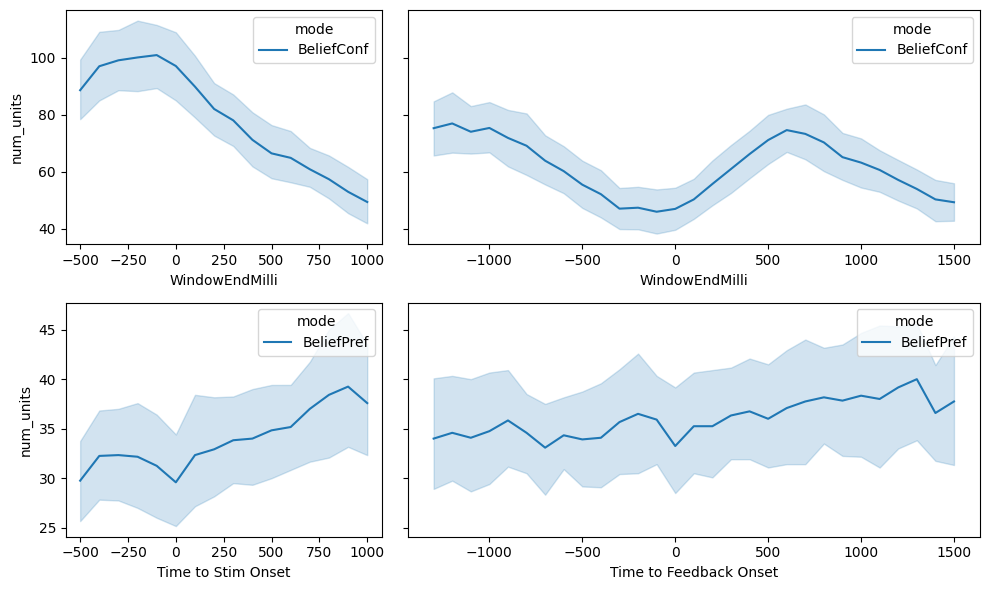

In [6]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500

plot_conf_pref(args, "95th")



### Split by regions?

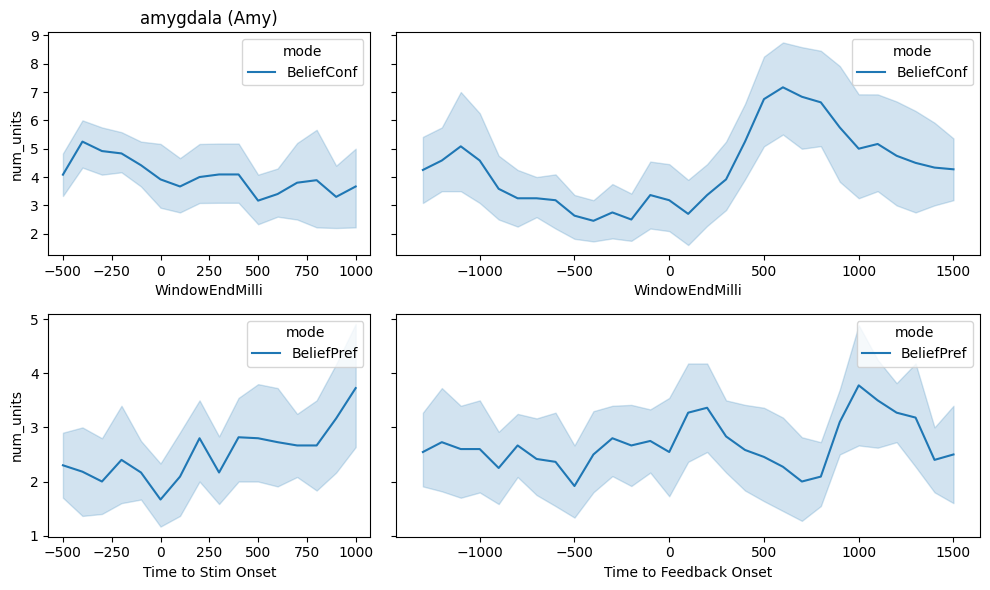

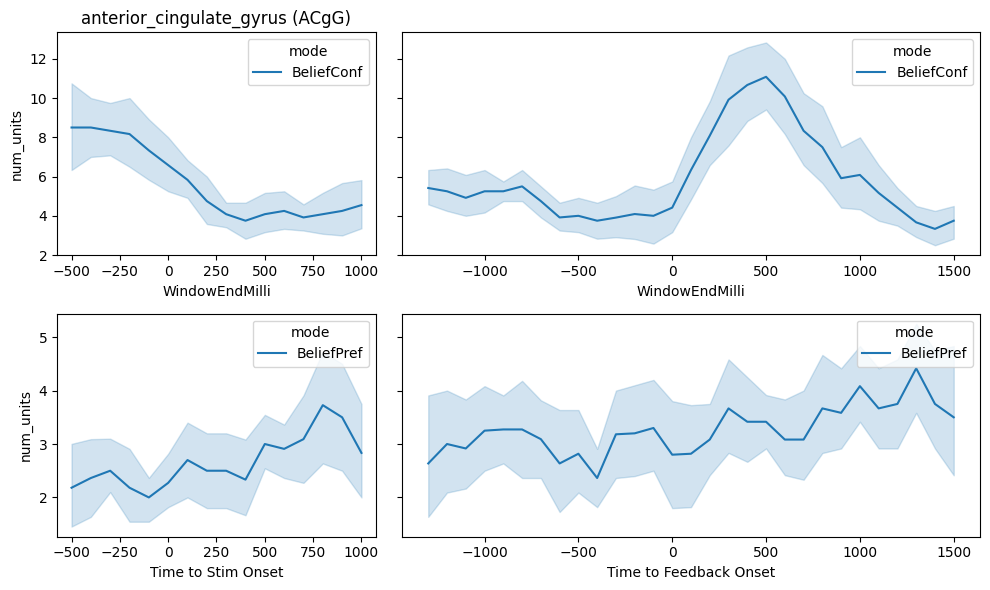

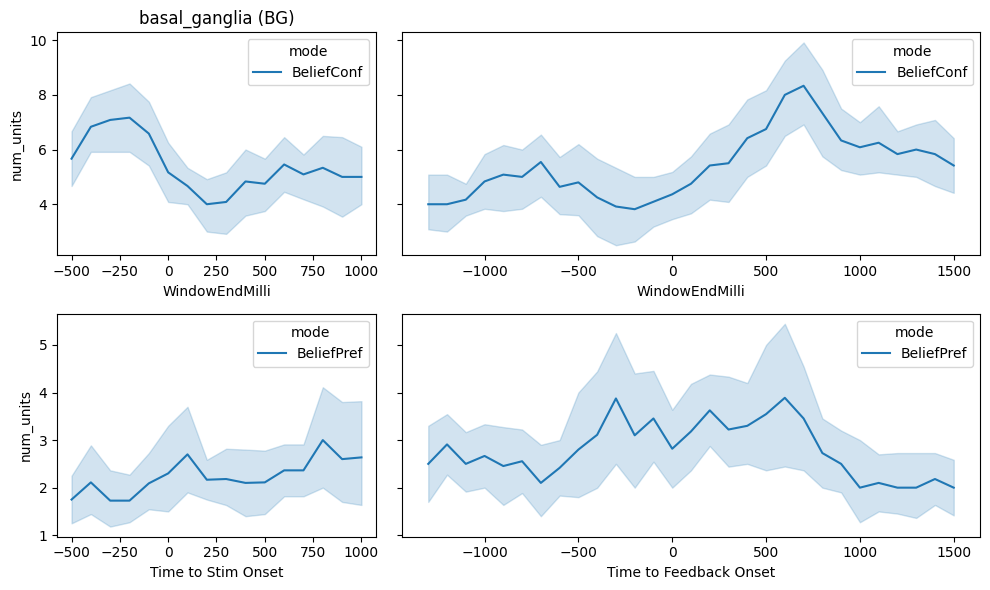

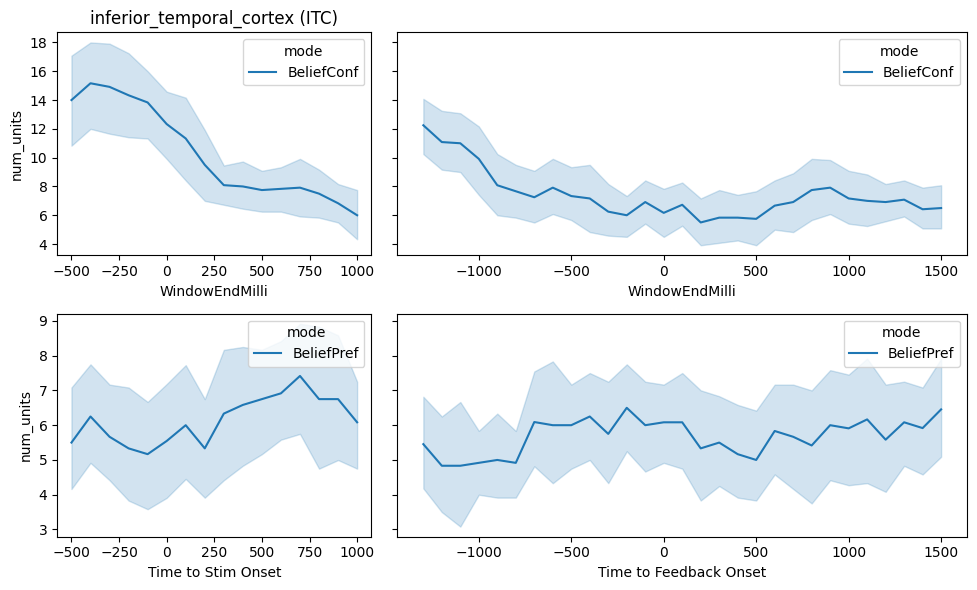

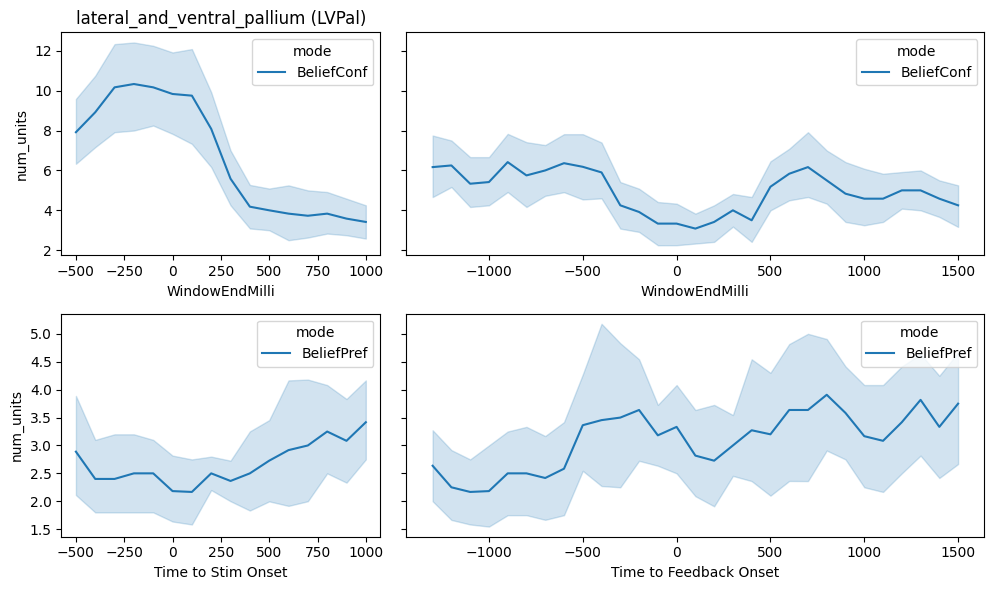

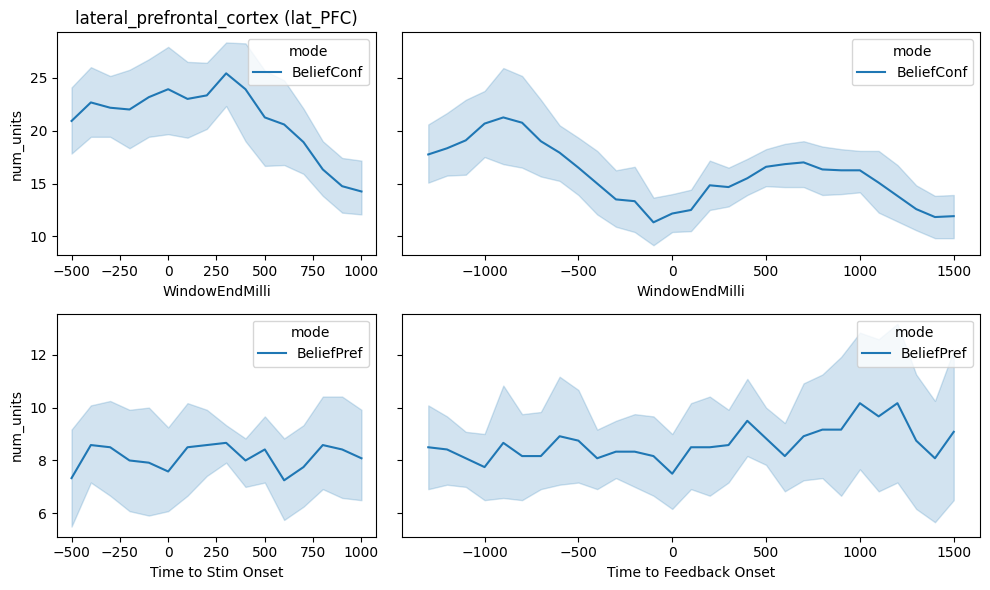

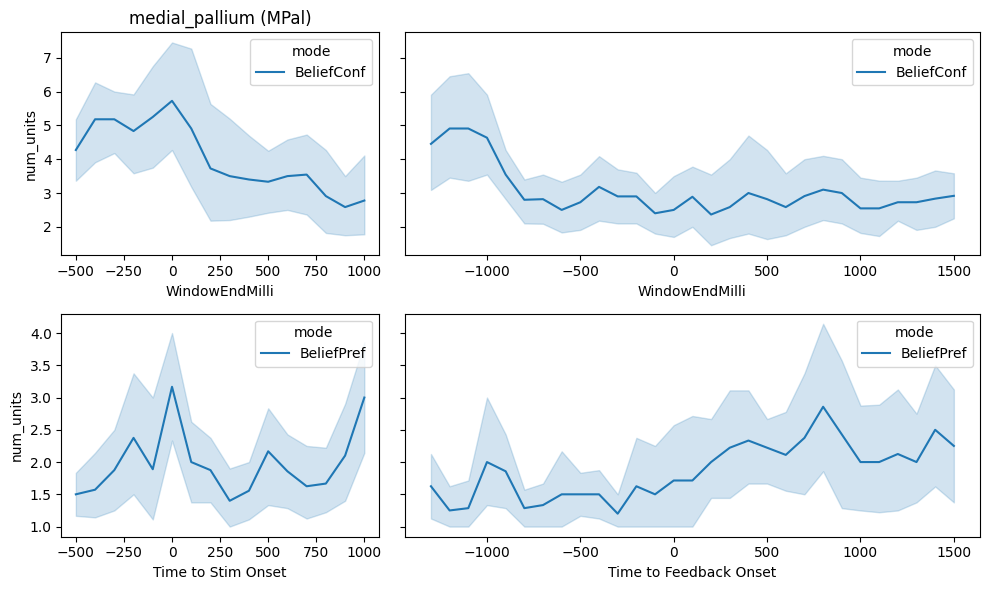

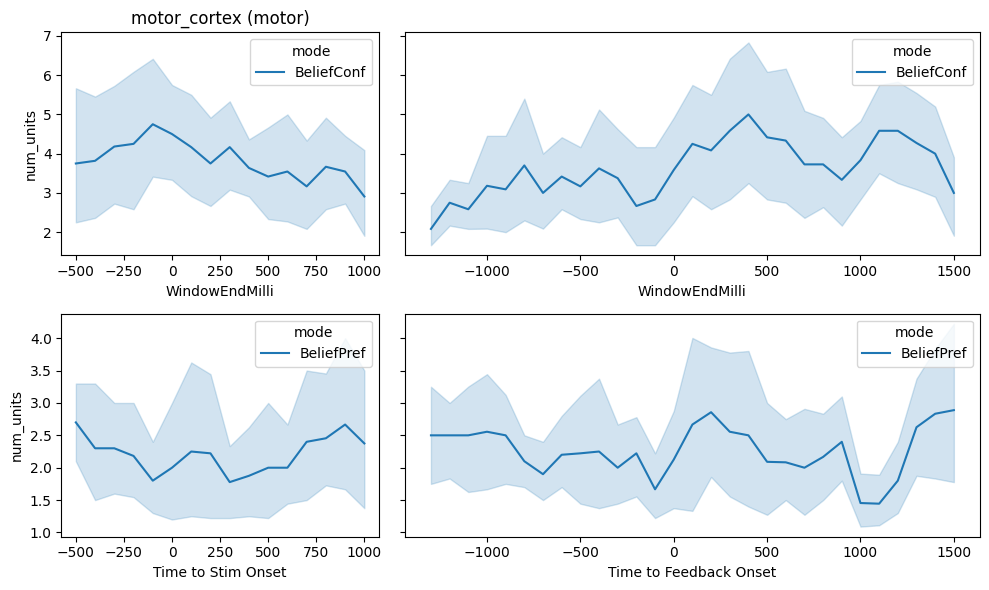

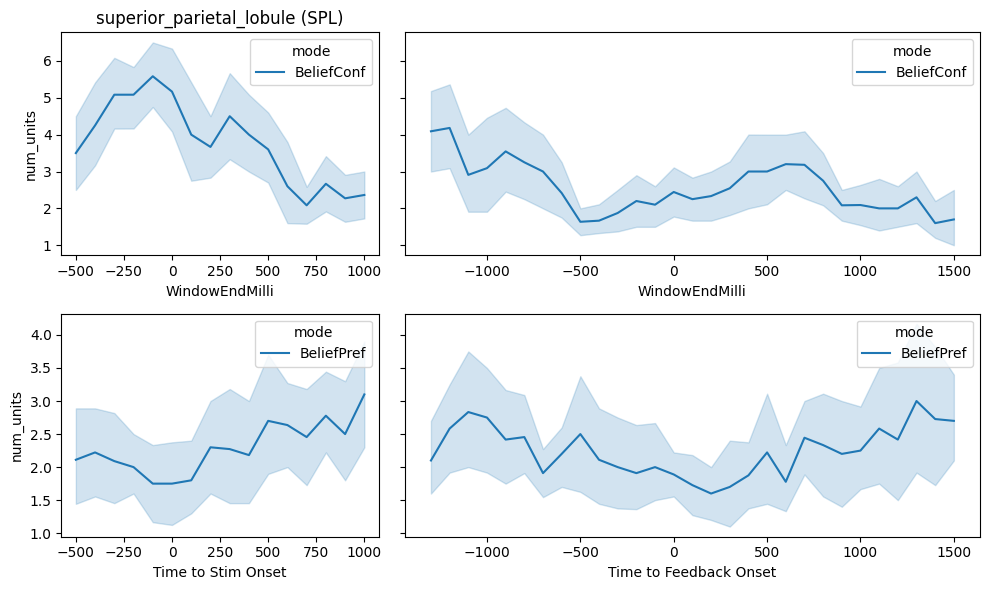

In [11]:
for region in region_totals.structure_level2:
    plot_conf_pref(args, "95th", region=region)


### Frac Var by total population

/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500


(<Figure size 1000x600 with 4 Axes>,
 array([[<Axes: xlabel='WindowEndMilli', ylabel='frac_variance'>,
         <Axes: xlabel='WindowEndMilli', ylabel='frac_variance'>],
        [<Axes: xlabel='Window End Time to Stim Onset', ylabel='frac_variance'>,
         <Axes: xlabel='Window End Time to Feedback Onset', ylabel='frac_variance'>]],
       dtype=object))

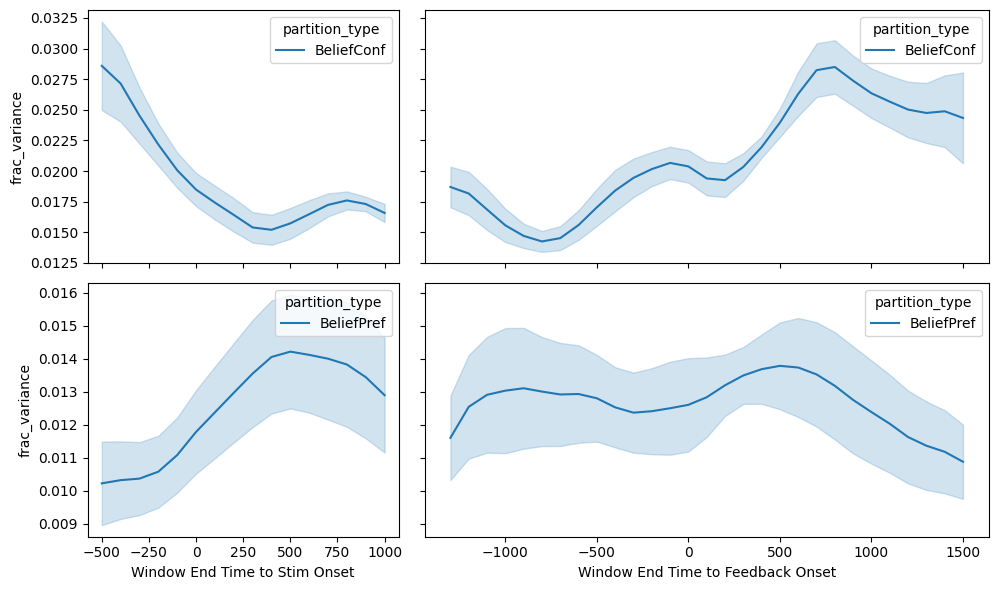

In [12]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = "BL"

# plot_frac_var_total_pop(args, next_modes=["NextBeliefConf", "NextBeliefPref"])
plot_frac_var_total_pop(args)

### Frac Var by total population, by drive:

/data/patrick_res/anova/SA_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500


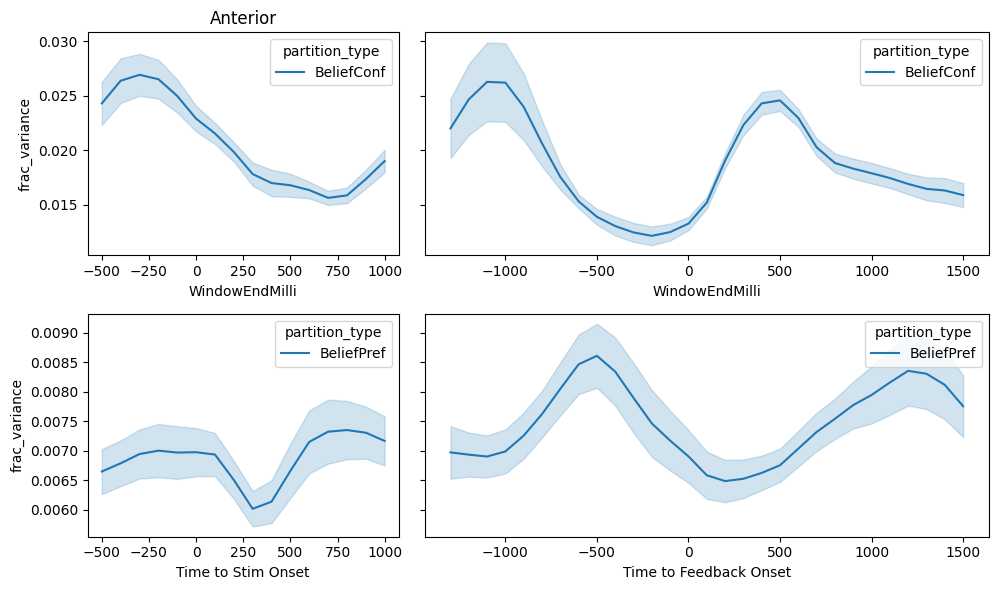

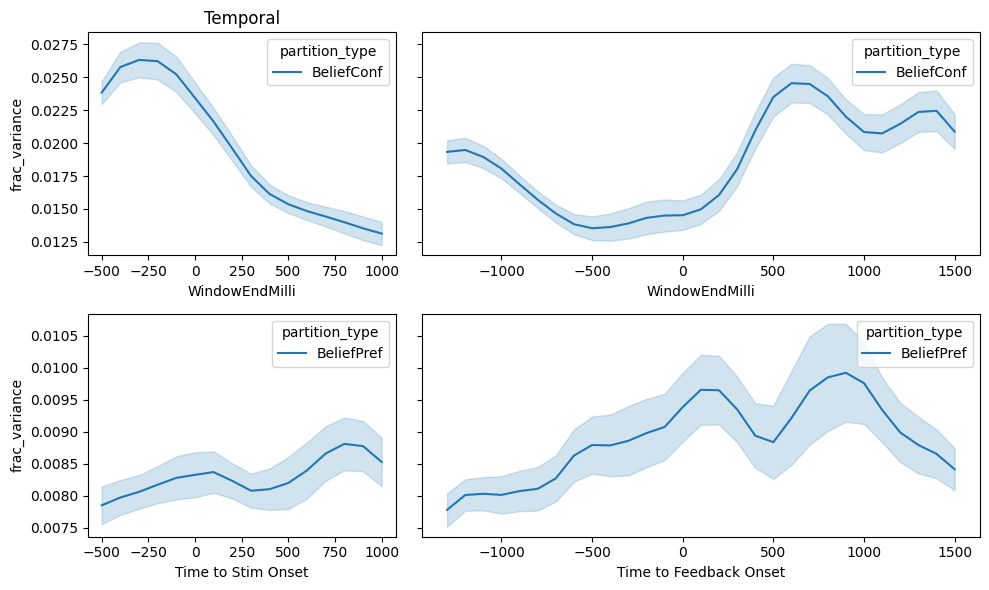

In [13]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)

args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500

for drive in ["Anterior", "Temporal"]:
    plot_frac_var_total_pop(args, region_level="drive", regions=[drive])

### Fraction of population variance by regions

/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500


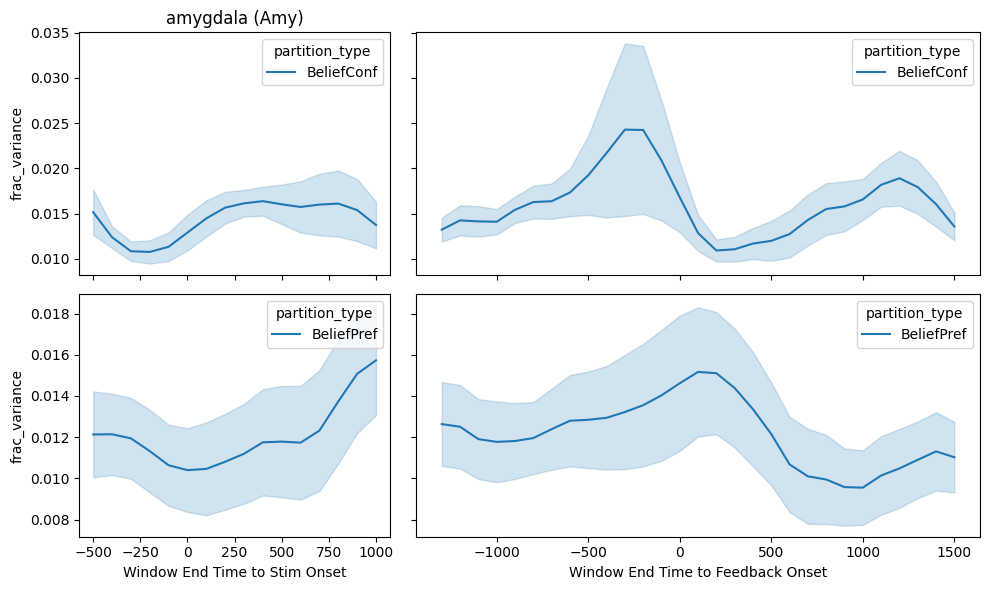

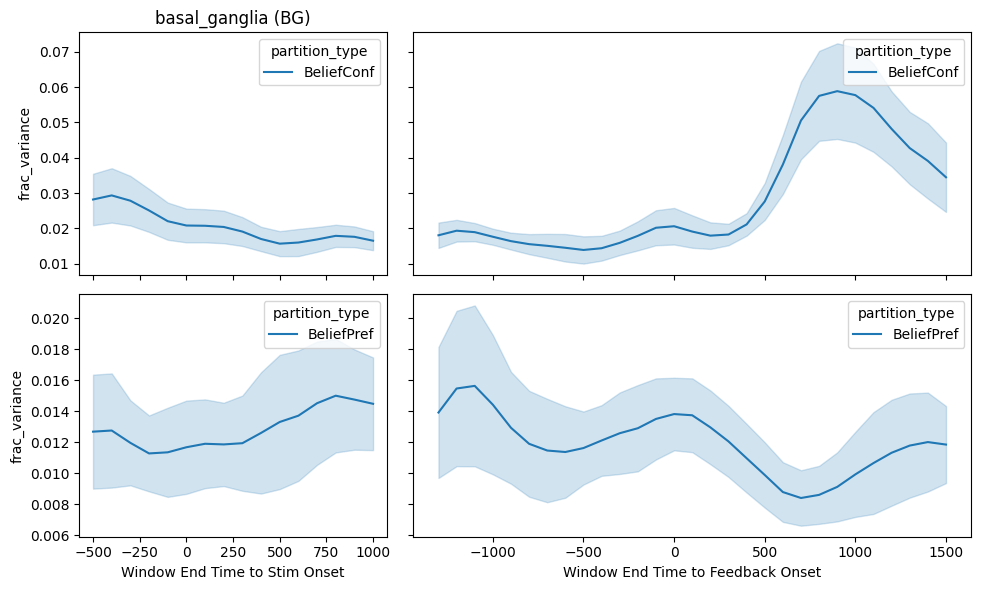

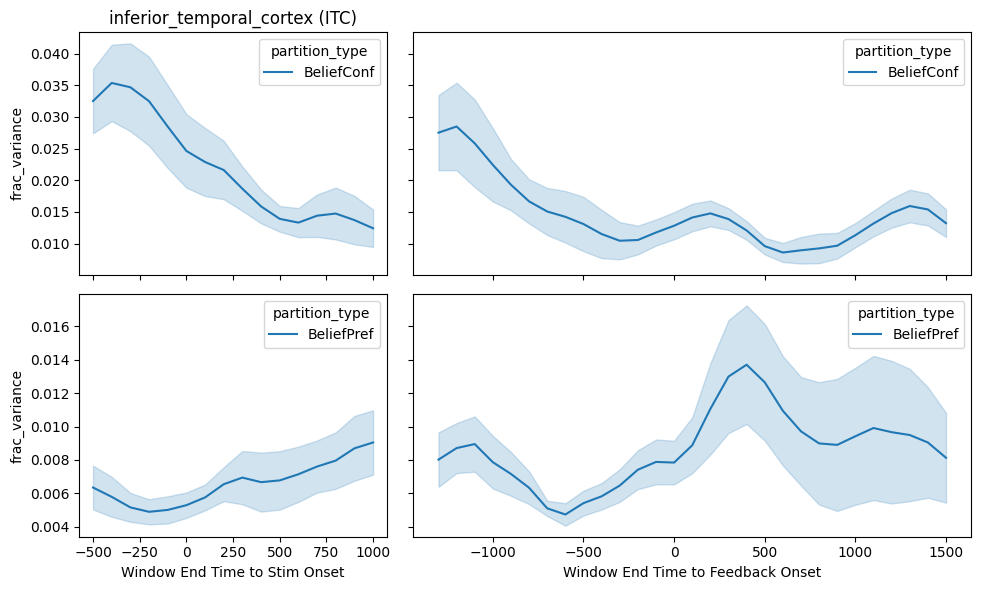

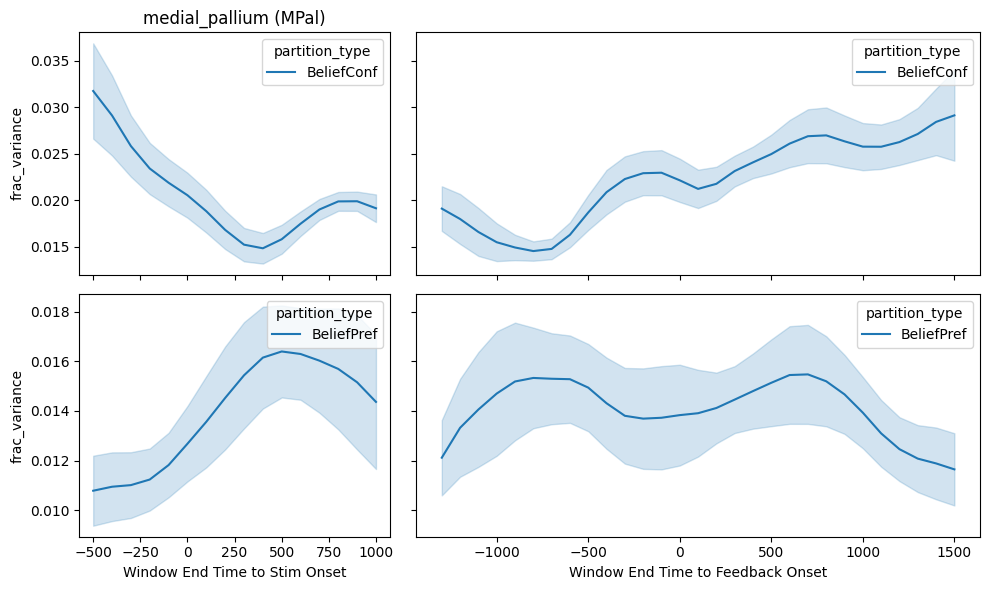

In [19]:
for region in region_totals.structure_level2:
    plot_frac_var_total_pop(args, regions=[region])

### Fraction of population variance, regions in the same plot

### Frac Var by belief partition variance

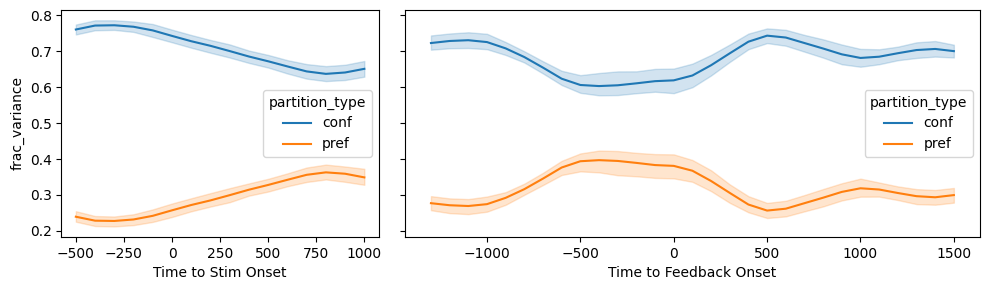

In [11]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500

plot_conf_pref_frac_var_belief_part(args)

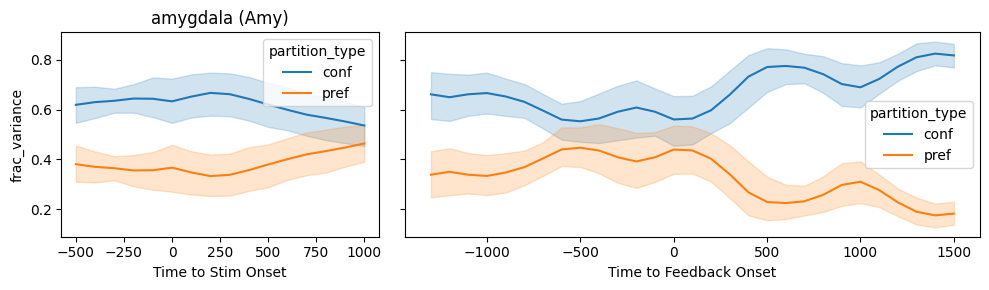

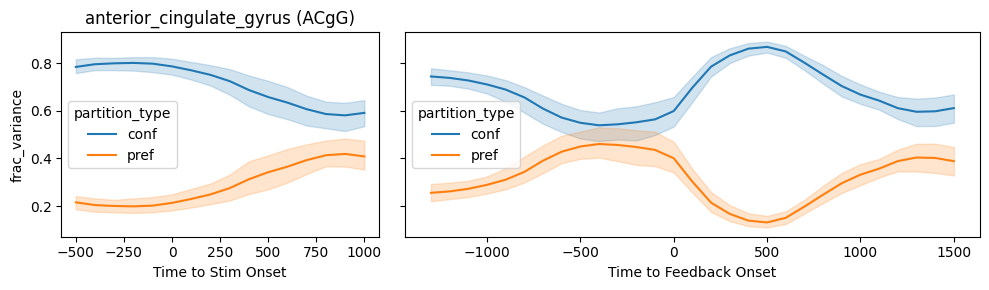

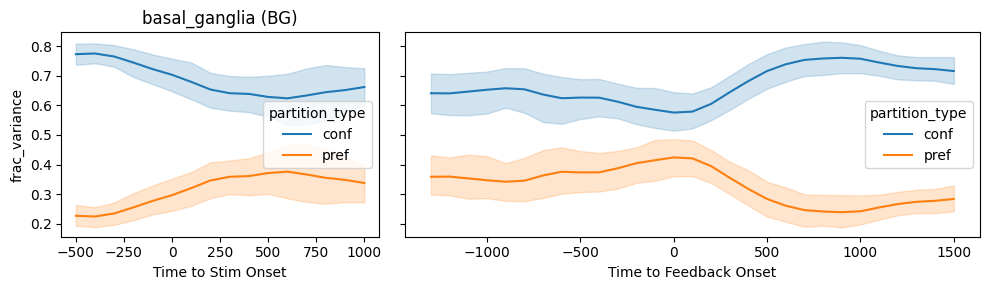

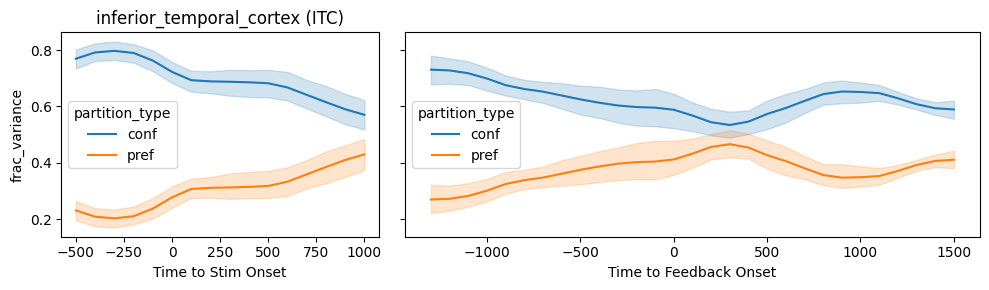

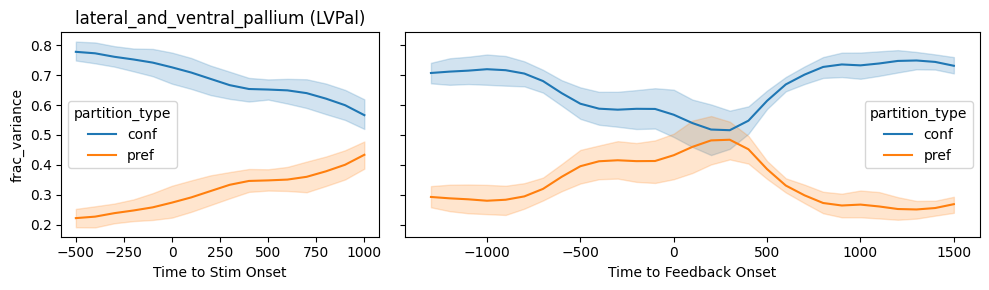

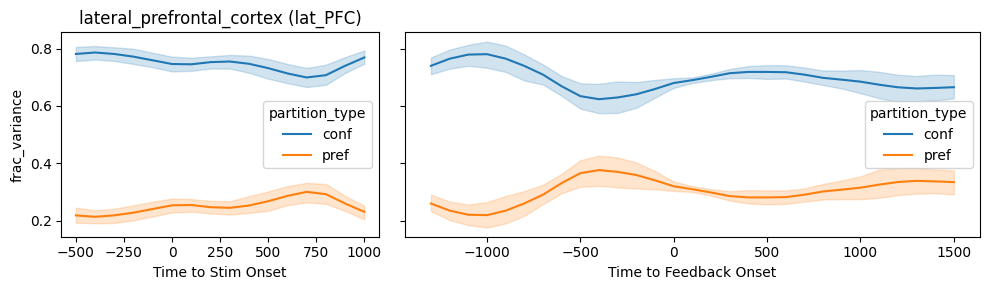

In [30]:
for region in region_totals.structure_level2:
    plot_conf_pref_frac_var_belief_part(args, region=region)

### Generate new subpopulation of neurons based off window significance

In [48]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500



In [56]:
args.trial_event = "StimOnset"
mode = "BeliefPref"
stim_res = io_utils.read_anova_good_units(args, "99th", mode)
stim_res["trial_event"] = args.trial_event

args.trial_event = "FeedbackOnsetLong"
fb_res = io_utils.read_anova_good_units(args, "99th", mode)
fb_res["trial_event"] = args.trial_event

all_res = pd.concat((stim_res, fb_res))

In [57]:
all_res.PseudoUnitID.nunique()

935

In [61]:
all_res.groupby("feat").PseudoUnitID.nunique()

feat
CIRCLE      206
CYAN        175
ESCHER      119
GREEN       152
MAGENTA     183
POLKADOT    146
RIPPLE      122
SQUARE      191
STAR        104
SWIRL       121
TRIANGLE    106
YELLOW      208
Name: PseudoUnitID, dtype: int64

In [58]:
all_res.columns

Index(['PseudoUnitID', 'total_var', 'x_TimeBins_fracvar',
       'x_BeliefConf_fracvar', 'x_BeliefPartition_fracvar',
       'x_TimeBinsBeliefConf_fracvar', 'x_TimeBinsBeliefPartition_fracvar',
       'x_BeliefConfBeliefPartition_fracvar',
       'x_TimeBinsBeliefConfBeliefPartition_fracvar', 'residual_fracvar',
       'sum_fracvar', 'x_BeliefConf_comb_time_fracvar',
       'x_BeliefPartition_comb_time_fracvar',
       'x_BeliefConfBeliefPartition_comb_time_fracvar',
       'x_BeliefPref_comb_time_fracvar', 'feat', 'WindowStartMilli',
       'WindowEndMilli', 'BeliefConf_95th', 'BeliefConf_99th',
       'BeliefPartition_95th', 'BeliefPartition_99th',
       'BeliefConfBeliefPartition_95th', 'BeliefConfBeliefPartition_99th',
       'BeliefPref_95th', 'BeliefPref_99th', 'drive', 'structure_level2',
       'trial_event'],
      dtype='object')

In [62]:
sig_units = all_res.groupby("feat").PseudoUnitID.unique().reset_index(name="PseudoUnitID").explode(column="PseudoUnitID")
sig_units.to_pickle(f"/data/patrick_res/firing_rates/{args.subject}/StimOnset_belief_pref_window_all_time_units.pickle")
sig_units.to_pickle(f"/data/patrick_res/firing_rates/{args.subject}/FeedbackOnsetLong_belief_pref_window_all_time_units.pickle")

how many units per feature are there total?

In [31]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
feats = pd.read_pickle(FEATS_PATH)
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))

In [38]:
feats.groupby("feat").apply(lambda x: unit_pos[unit_pos.session.isin(x.sessions.iloc[0])].PseudoUnitID.nunique()).reset_index(name="num_units")

,feat,num_units
0,CIRCLE,635
1,CYAN,562
2,ESCHER,411
3,GREEN,514
4,MAGENTA,601
5,POLKADOT,512
6,RIPPLE,431
7,SQUARE,636
8,STAR,384
9,SWIRL,417


### In common regions for Blanche and Sam, generate frac of variance plots for both monkeys, overlaid:

/data/patrick_res/anova/SA_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova/SA_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose_window_500
/data/patrick_res/anova

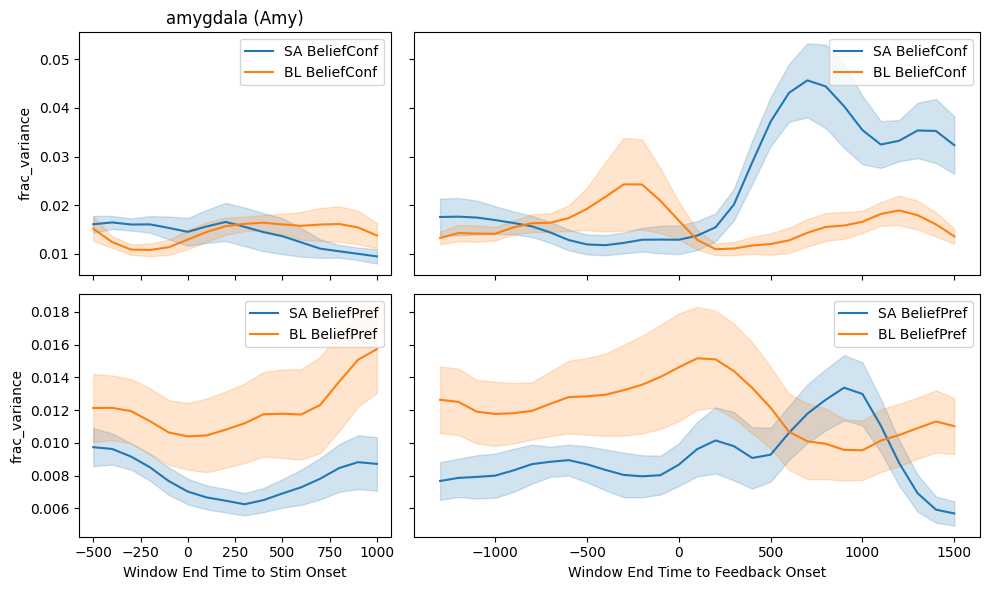

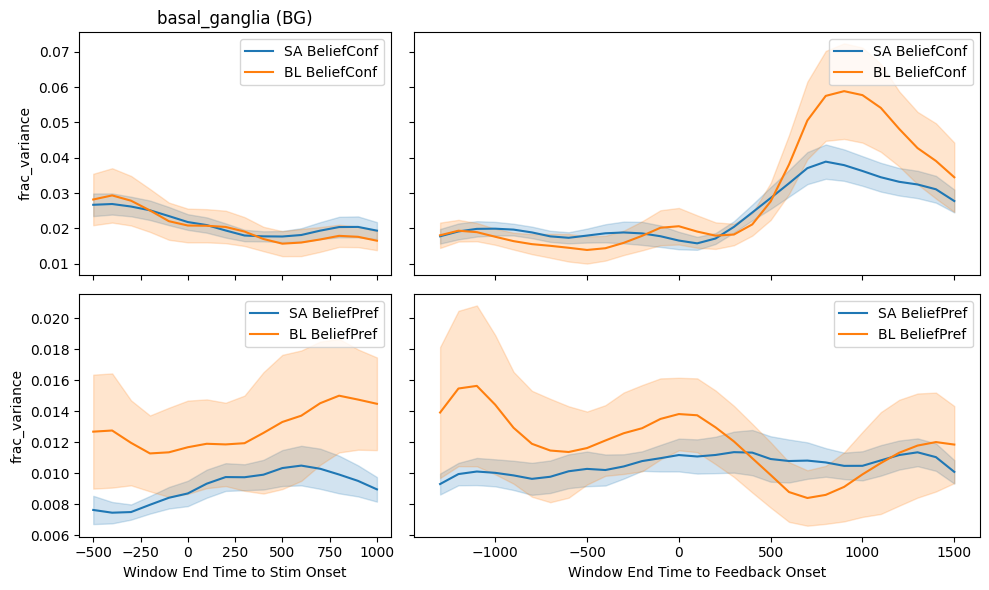

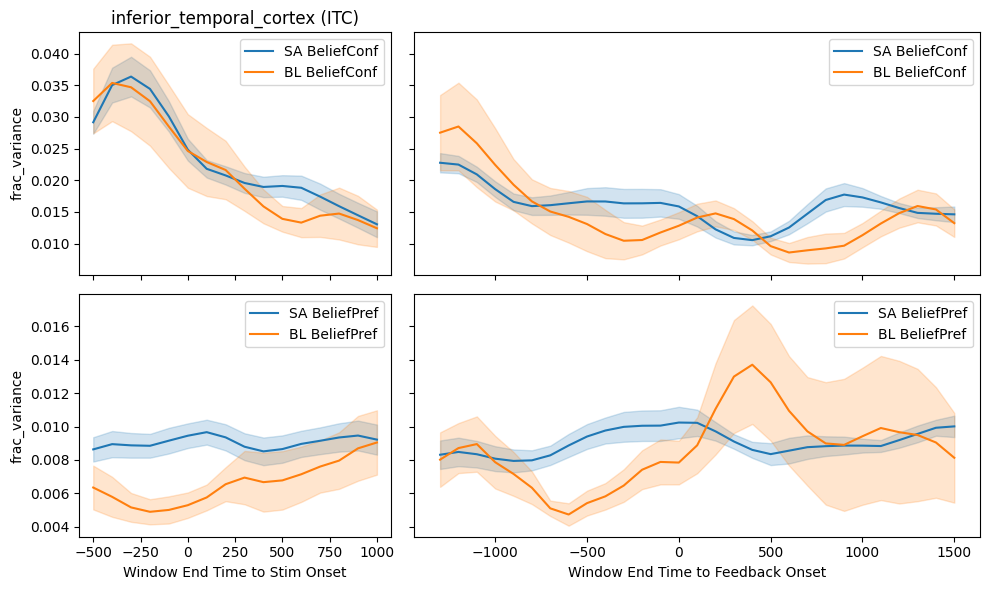

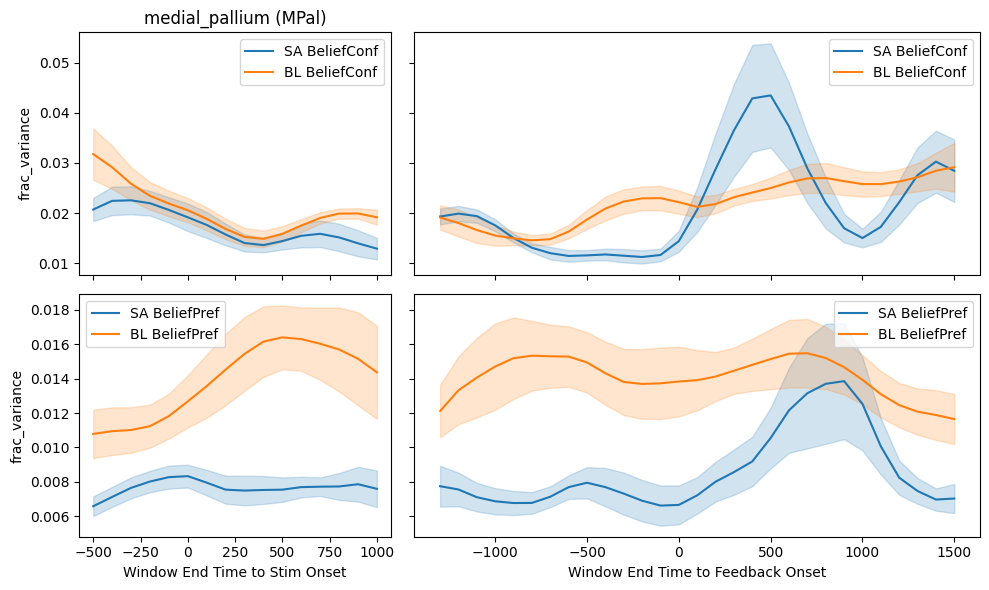

In [7]:
common_regions = ["amygdala (Amy)", "basal_ganglia (BG)", "inferior_temporal_cortex (ITC)", "medial_pallium (MPal)"]
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500

for region in common_regions:
    args.subject = "SA"
    fig, axs = plot_frac_var_total_pop(args, regions=[region], subject="SA")
    args.subject = "BL"
    plot_frac_var_total_pop(args, regions=[region], fig=fig, axs=axs, subject="BL")
